seed = 52772
Classes: ['malignant' 'benign']
Standard scaling will not change y, so class balance stays the same before and after standardization.
Train: n=341
class Malignant(0): 127 (37.2%)
class Benign(1): 214 (62.8%)
Val: n=114
class Malignant(0): 43 (37.7%)
class Benign(1): 71 (62.3%)
Test: n=114
class Malignant(0): 42 (36.8%)
class Benign(1): 72 (63.2%)


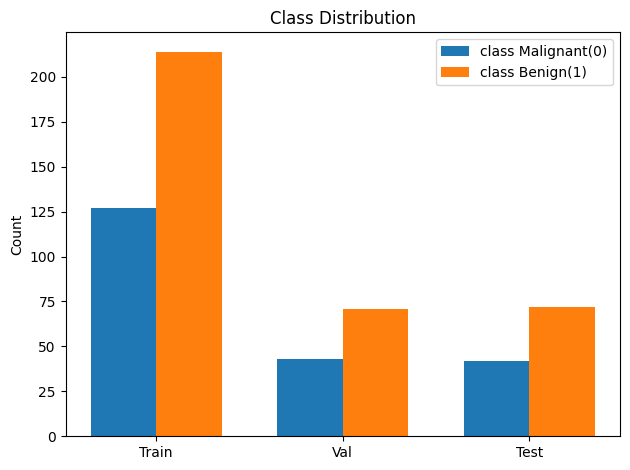

In [136]:
# 2 Task 2: Classification — Probabilistic & Linear Models
# Dataset: Breast Cancer Wisconsin (Diagnostic).
# Goal: Implement GNB, GDA (shared and class-specific covariance), Logistic Regression via
# gradient descent, and Perceptron (or averaged perceptron) from scratch.

# 2.1 2A. Data Preprocessing (Required)
# 1. Use your seed to create a 60/20/20 train/validation/test split.
# 2. Standardize features (justify if you choose otherwise).
# 3. Report class balance and at least one visualization.
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

with open("seed.txt", "r") as f:
    seed = int(f.read().strip())

print(f"seed = {seed}")

#Load dataset
data = load_breast_cancer()
X = data.data.astype(float)          
y = data.target.astype(int)          
feature_names = data.feature_names
target_names = data.target_names  

print(f"Classes: {target_names}")

#60/20/20 split with stratification
X_train_raw, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=seed, stratify=y
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=seed, stratify=y_temp
)

#Standardize using TRAIN statistics only
mu = X_train_raw.mean(axis=0)
sigma = X_train_raw.std(axis=0, ddof=0)
sigma[sigma == 0] = 1.0  #prevents division by zero

X_train = (X_train_raw - mu) / sigma
X_val   = (X_val_raw   - mu) / sigma
X_test  = (X_test_raw  - mu) / sigma

#Class balance reporting helper
def report_balance(name, y_split):
    n = len(y_split)
    
    #count how many samples belong to each class; binary classification 0 or 1
    counts = np.bincount(y_split, minlength=2) 

    #convert count to percentage
    percentage = counts / n * 100 

    print(f"{name}: n={n}")
    print(f"class Malignant(0): {counts[0]} ({percentage[0]:.1f}%)")
    print(f"class Benign(1): {counts[1]} ({percentage[1]:.1f}%)")


print("Standard scaling will not change y, so class balance stays the same before and after standardization.")
report_balance("Train", y_train)
report_balance("Val", y_val)
report_balance("Test", y_test)

# Visualization
splits = ["Train", "Val", "Test"]
counts0 = [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)]
counts1 = [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)]

x = np.arange(3)
width = 0.35

plt.figure()
plt.bar(x - width/2, counts0, width, label="class Malignant(0)")
plt.bar(x + width/2, counts1, width, label="class Benign(1)")
plt.xticks(x, splits)
plt.ylabel("Count")
plt.title("Class Distribution")
plt.legend()
plt.tight_layout()
plt.show()




In [137]:
# 2.3 2C. Implementations (From Scratch)
# 1. Gaussian Naive Bayes (log-probabilities required)
class GaussianNaiveBayes:
    #prior: probability of each class before seeing any features
    """logP(y=c|x)∝logP(y=c)+logP(x|y=c)"""
    """logP(y=c) -> prior"""
    """logP(x|y=c) -> log_likelihood() implemented below"""
    def __init__(self):
        self.classes = None
        self.priors = {}
        self.means = {}
        self.varians = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        n = len(y) 
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = len(X_c) / n
            self.means[c] = X_c.mean(axis=0)
            self.varians[c] = X_c.var(axis=0) + 1e-9 #numerical smoothing
        return self
    
    def log_likelihood(self, X, c):
        mean = self.means[c]
        varian = self.varians[c]
        # computer log P(x | class=c)
        log_prob = -0.5 * (np.log(2 * np.pi * varian) + (X -  mean)**2 / varian)
        return log_prob.sum(axis=1)
    
    def predict(self, X):
        log_posteriors = []
        for c in self.classes:
            log_prior = np.log(self.priors[c])
            log_ll = self.log_likelihood(X, c)
            log_posteriors.append(log_prior + log_ll)
        log_posteriors = np.array(log_posteriors)
        return self.classes[np.argmax(log_posteriors,axis=0)]


In [138]:
# 2. GDA with shared covariance and class-specific covariance
class GDA:
    def __init__(self, shared_covariance=True):
        self.shared_covariance = shared_covariance
        self.classes = None
        self.priors = {}
        self.means = {}
        self.covs = {}
        self.shared_cov_matrix = None


    def fit(self, X, y):
        self.classes = np.unique(y)
        n, d = X.shape
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = len(X_c) / n
            self.means[c] = X_c.mean(axis=0)
            self.covs[c] = np.cov(X_c, rowvar=False) + 1e-6 * np.eye(d) # add a tiny value to the diagonal

        if self.shared_covariance:
            self.shared_cov_matrix = np.zeros((d, d))
            for c in self.classes:
                n_c = np.sum(y == c)
                self.shared_cov_matrix += (n_c - 1) * self.covs[c]
            self.shared_cov_matrix /= (n - len(self.classes))
            self.shared_cov_matrix += 1e-6 * np.eye(d)
        return self

    #look up chatGPT: "multivariate Guassian Log-Density"
    def _log_likelihood(self, X, c):
        mean = self.means[c]
        cov = self.shared_cov_matrix if self.shared_covariance else self.covs[c]
        d = X.shape[1]
        diff = X - mean
        # mutilvariate Gaussian Log-Density
        # log N(x; mu, Sigma) = -0.5 * [d*log(2*pi) + log|Sigma| + (x-mu)^T Sigma^{-1} (x-mu)]
        sign, logdet = np.linalg.slogdet(cov) #log|sigma|
        cov_inv = np.linalg.inv(cov) 
        mahal = np.sum(diff @ cov_inv * diff, axis=1) #(x-mu)^T Sigma^{-1} (x-mu)
        return -0.5 * (d * np.log(2 * np.pi) + logdet + mahal)

    def predict(self, X):
        log_posteriors = []
        for c in self.classes:
            log_prior = np.log(self.priors[c])
            log_ll = self._log_likelihood(X, c)
            log_posteriors.append(log_prior + log_ll)
        log_posteriors = np.array(log_posteriors)
        return self.classes[np.argmax(log_posteriors, axis=0)]


In [139]:
# 3. Logistic Regression using batch gradient descent (with optional L2)

class LogisticRegression:
    def __init__(self, lr=0.1, epochs=2000, l2=0.0, tol=1e-7):
        """
        lr: learning rate
        epochs: max iterations
        l2: L2 strength (lambda). 0.0 means no regularization.
        tol: stop if parameter change is tiny
        """
        self.lr = lr
        self.epochs = epochs
        self.l2 = l2
        self.tol = tol
        self.weights = None
        self.bias = 0
        

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def cost(self, h, y):
        """Binary cross-entropy loss: Jdata = -m1​∑[ylog(h)+(1-y)log(1-h)]"""
        """J = J(data) + J(reg)"""
        m = len(y)
        eps = 1e-12
        h = np.clip(h, eps, 1 - eps) # prevent log(0)

        binary_cross_entropy = - (1/m) * np.sum(y*np.log(h) + (1-y)*np.log(1-h))
        reg = (self.lam / (2*m)) * np.sum(self.theta[1:]**2) #[1:] -> intercept not regularized
        
        return binary_cross_entropy + reg

    def fit(self, X, y):
        """Train model using gradient descent"""
        m, n = X.shape
        self.weights = np.zeros(n)

        for _ in range(self.epochs):
            z = np.dot(X, self.weights) + self.bias
            h = self.sigmoid(z)

            dw = (1/m) * np.dot(X.T, (h - y))
            db = (1/m) * np.sum(h - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db
        return self
    
    def predict(self, X):
        return (self.sigmoid(np.dot(X, self.weights) + self.bias) >= 0.5).astype(int)

         

In [140]:
# 4. Perceptron (or averaged perceptron)
class Perceptron:
    # lr: learning rate
    # epochs: the number of times the algorithms goes through during learning 
    # w: weights
    # b: bias
    def __init__(self, lr=0.1, epochs=1000, fit_intercept=True, convergence_tolerance = 1e-6):
        self.lr =  lr
        self.epochs = epochs
        self.fit_intercept = fit_intercept
        self.w = None
        self.b = 0.0
        self.n_features = None
        self.convergence_tolerance = convergence_tolerance

    def fit(self, X, y):
        
        n, p = X.shape
        #initilization
        self.n_features = p
        self.w = np.zeros(p)

        for _ in range(self.epochs):
            #save for convergence checking
            w_old = self.w.copy()
            b_old = self.b

            for i in range(n):
                xi = X[i]
                yi = y[i]

                score = xi @ self.w + (self.b if self.fit_intercept else 0.0)
                y_pred = 1 if score >=0 else -1

                # learning - update w and b if misclassify
                if y_pred != yi:
                    self.w += self.lr * yi * xi
                    if self.fit_intercept:
                        self.b += self.lr * yi
            w_change = np.linalg.norm(self.w - w_old)
            b_change = abs(self.b -b_old) if self.fit_intercept else 0.0

            if w_change < self.convergence_tolerance and b_change <self.convergence_tolerance:
                #print(f"Converged!")
                break

        return self
    def predict(self, X):
        X = np.asarray(X, dtype=float)
        scores = X @ self.w + (self.b if self.fit_intercept else 0.0)
        return (scores >=0).astype(int)
            

In [141]:
# Report on test set:
# • Accuracy, Precision, Recall, F1
# • Confusion matrix
def metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    #construct confusion matrix
    cm = np.array([[tp,fn],[fp,tn]])
    # print(f"True positive: {tp}, False positive: {fp}, True negative: {tn}, False negative: {fn}")
    # print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
    # print(f"Confusion Matrix: {cm}")

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall,
            'f1': f1, "confusion": cm}



In [143]:
# fit models

gnb = GaussianNaiveBayes().fit(X_train, y_train)
gda_shared = GDA(shared_covariance=True).fit(X_train, y_train)
gda_specific = GDA(shared_covariance=False).fit(X_train, y_train)
log_reg = LogisticRegression(lr=0.1, epochs=1000).fit(X_train, y_train)
perceptron = Perceptron(lr=0.1, epochs=1000).fit(X_train, y_train)

def evaluate_models(y_true, model_preds):
    results = {}

    header = f"{'Model':<25} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}"
    print(header)
    print("-" * len(header))

    for name, y_pred in model_preds.items():
        m = metrics(y_true, y_pred)
        results[name] = m

        print(f"{name:<25} "
              f"{m['accuracy']:>10.4f} "
              f"{m['precision']:>10.4f} "
              f"{m['recall']:>10.4f} "
              f"{m['f1']:>10.4f}")

    return results

model_predictions = {
    "GNB": gnb.predict(X_test),
    "GDA (Shared)": gda_shared.predict(X_test),
    "GDA (Class-specific)": gda_specific.predict(X_test),
    "Logistic Regression": log_reg.predict(X_test),
    "Perceptron": perceptron.predict(X_test),
}
all_metrics = evaluate_models(y_test, model_predictions)


Model                       Accuracy  Precision     Recall         F1
---------------------------------------------------------------------
GNB                           0.1140     0.2264     0.1667     0.1920
GDA (Shared)                  0.9298     0.9000     1.0000     0.9474
GDA (Class-specific)          0.9649     0.9722     0.9722     0.9722
Logistic Regression           0.9737     0.9726     0.9861     0.9793
Perceptron                    0.6316     0.6316     1.0000     0.7742
